In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/airports.csv', index_col=0)

In [3]:
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,NaN,NaN,123.0,NaN,0.0,343.0,533.0,NaN,283.0,NaN,14.0,389.0,50.0,318.0,NaN,1.0
2018-12-30 01:00:00,14.0,14.0,NaN,NaN,52.0,NaN,147.0,84.0,11.0,NaN,290.0,NaN,11.0,64.0,12.0,7.0,NaN,NaN
2018-12-30 02:00:00,29.0,10.0,NaN,NaN,19.0,NaN,NaN,60.0,NaN,NaN,314.0,NaN,24.0,16.0,110.0,NaN,NaN,NaN
2018-12-30 03:00:00,115.0,216.0,NaN,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,NaN,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [4]:
df = df.fillna(0)
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,0.0,0.0,123.0,0.0,0.0,343.0,533.0,0.0,283.0,0.0,14.0,389.0,50.0,318.0,0.0,1.0
2018-12-30 01:00:00,14.0,14.0,0.0,0.0,52.0,0.0,147.0,84.0,11.0,0.0,290.0,0.0,11.0,64.0,12.0,7.0,0.0,0.0
2018-12-30 02:00:00,29.0,10.0,0.0,0.0,19.0,0.0,0.0,60.0,0.0,0.0,314.0,0.0,24.0,16.0,110.0,0.0,0.0,0.0
2018-12-30 03:00:00,115.0,216.0,0.0,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,0.0,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [5]:
df.isna().any().sum()

0

In [6]:
df.duplicated().any()

False

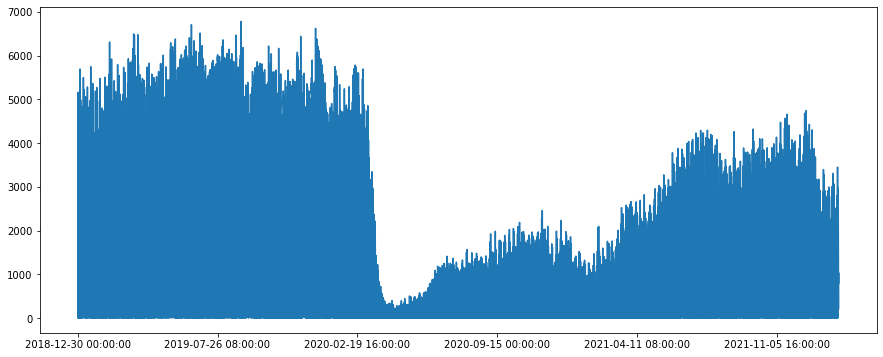

In [7]:
df.SFO.plot(figsize=(15,6));

In [8]:
decomposition = seasonal_decompose(df.SFO, period=24)

<Figure size 432x288 with 0 Axes>

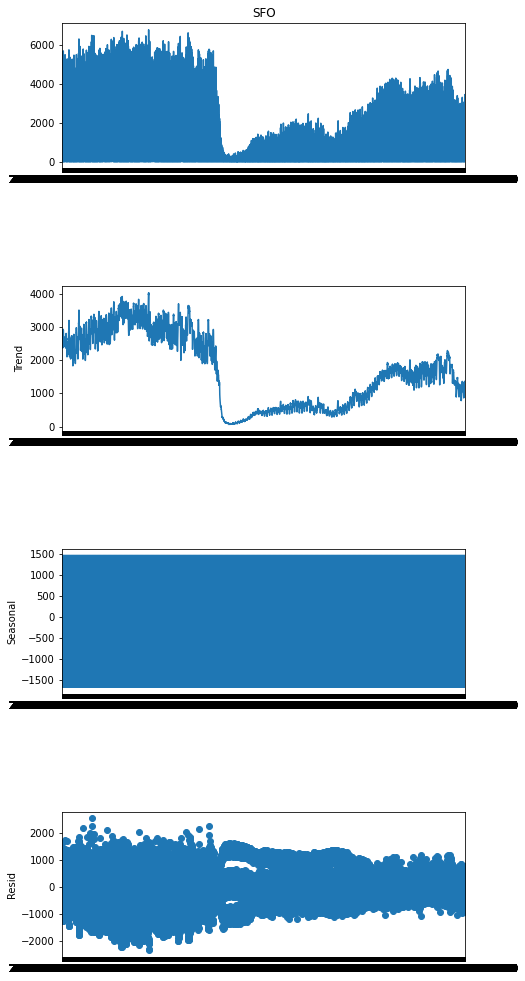

In [9]:
fig = plt.figure()  
fig = decomposition.plot();  
fig.set_size_inches(8, 16)

276.0974183583407


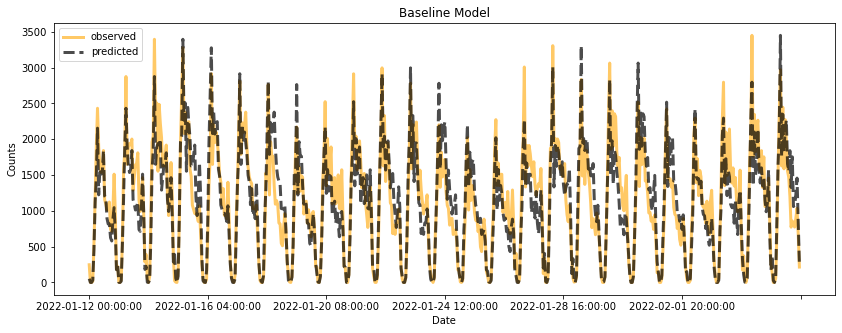

In [8]:
# Base model using yesterday's data, train
import matplotlib.dates as mdates
from datetime import datetime

base_model_prediction = df.SFO.shift(24)

error = (df.SFO-base_model_prediction).dropna()
print(sum(abs(error))/len(error))

ax = df.SFO.iloc[-600:].plot(label='observed', figsize=(14,5), linewidth = 3, color='orange', alpha=0.6)
base_model_prediction[-600:].plot(ax = ax, alpha=0.7, label='predicted', linewidth=3, color='black', linestyle='--')
ax.set_title('Baseline Model')
ax.set_xlabel('Date')
ax.set_ylabel('Counts')

ax.legend()

plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

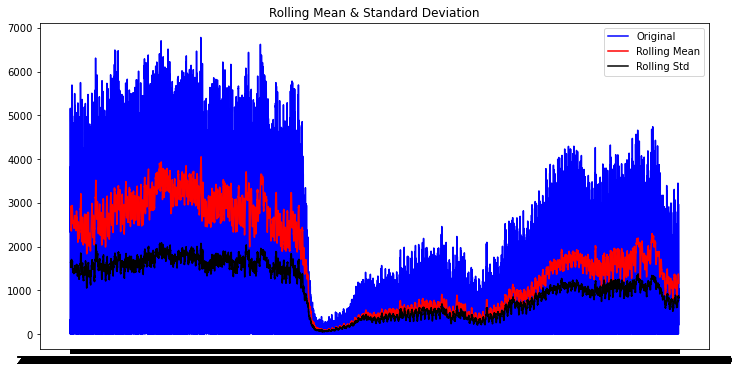

Results of Dickey-Fuller Test:
Test Statistic                    -3.123940
p-value                            0.024831
#Lags Used                        49.000000
Number of Observations Used    27166.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [6]:
test_stationarity(df.SFO)

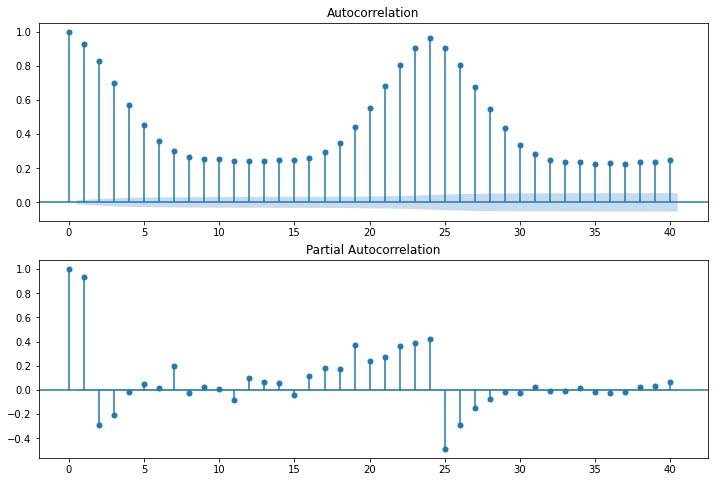

In [12]:
# Autocorrelation and Partial Autocorrelation Plots for original timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.SFO.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.SFO.dropna(), lags=40, ax=ax2)

The autocorrelation plot decays slowly. The series is not stationary.

Seasonality with period 24

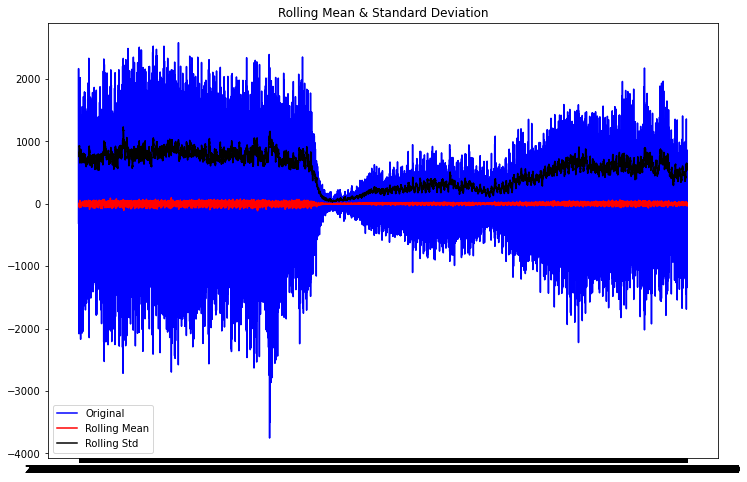

Results of Dickey-Fuller Test:
Test Statistic                   -36.546992
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27165.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [13]:
# First differenced
df['first_difference']=df.loc[:,'SFO'] - df.loc[:,'SFO'].shift(1)
test_stationarity(df.first_difference.dropna())

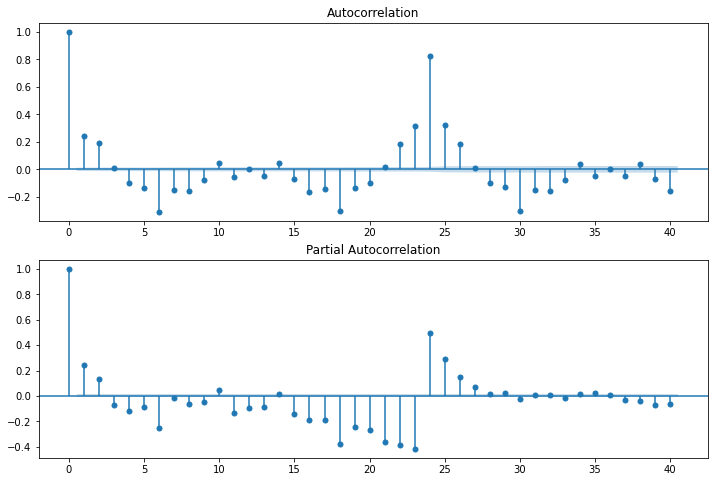

In [14]:
# Autocorrelation and Partial Autocorrelation Plots for first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=40, ax=ax2)

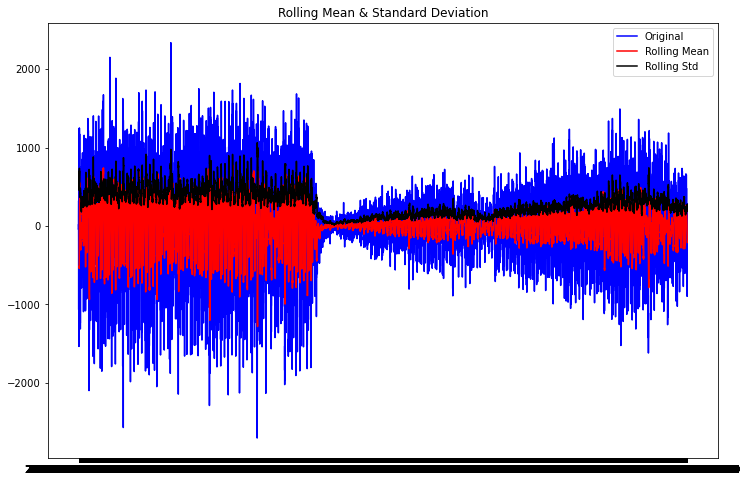

Results of Dickey-Fuller Test:
Test Statistic                   -32.831917
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27142.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [19]:
# Seasonal differenced
df['seasonal_difference']=df.SFO - df.SFO.shift(24)
test_stationarity(df.seasonal_difference.dropna())

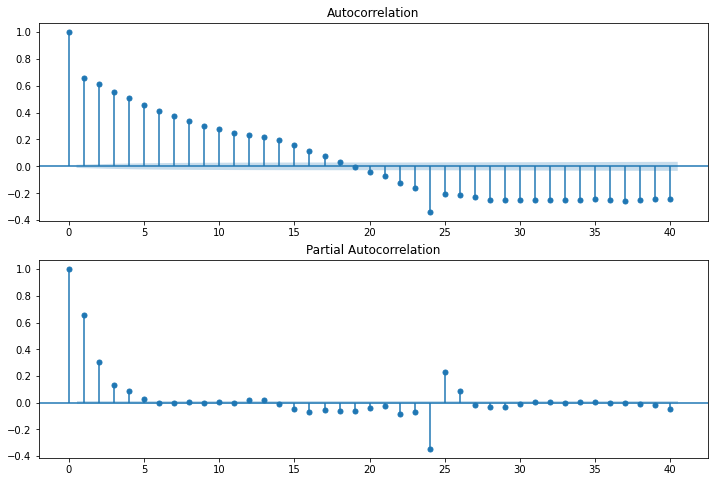

In [20]:
# Autocorrelation and Partial Autocorrelation Plots for seasonally differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=40, ax=ax2)

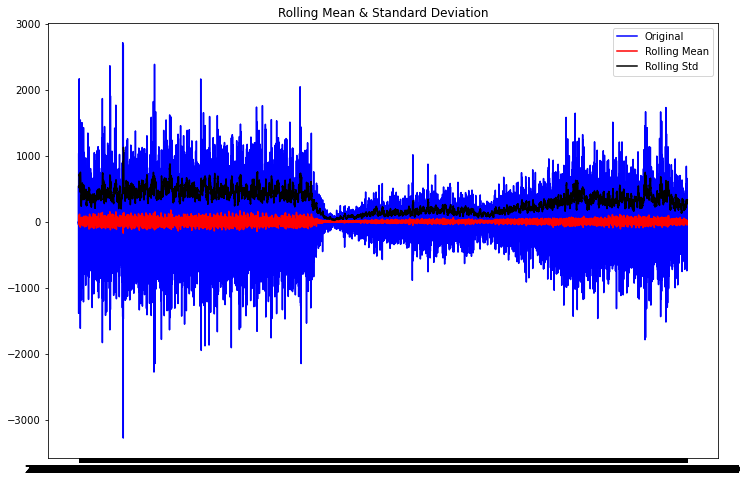

Results of Dickey-Fuller Test:
Test Statistic                   -40.758452
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27141.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [21]:
# Seasonal and non-seasonal differenced
df['seasonal_first_difference']=df.first_difference - df.first_difference.shift(24)
test_stationarity(df.seasonal_first_difference.dropna())

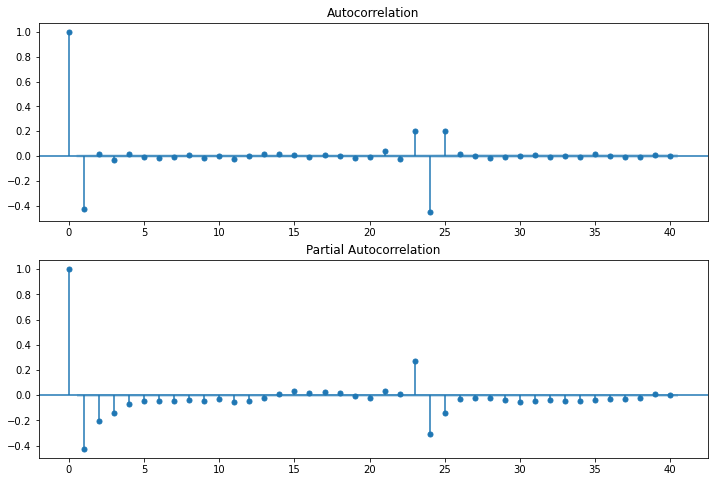

In [22]:
# Autocorrelation and Partial Autocorrelation Plots for first and seaonal first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=40, ax=ax2)

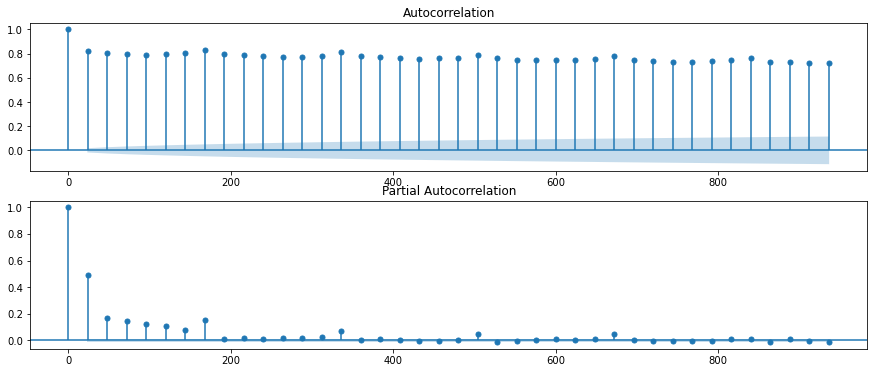

In [25]:
# Seasonal autocorrelation for first differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

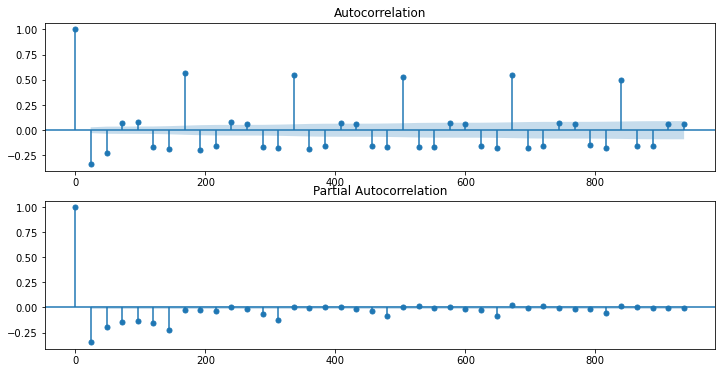

In [23]:
# Seasonal autocorrelation for seasonally adjusted series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=lags, ax=ax2)
plt.show()

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


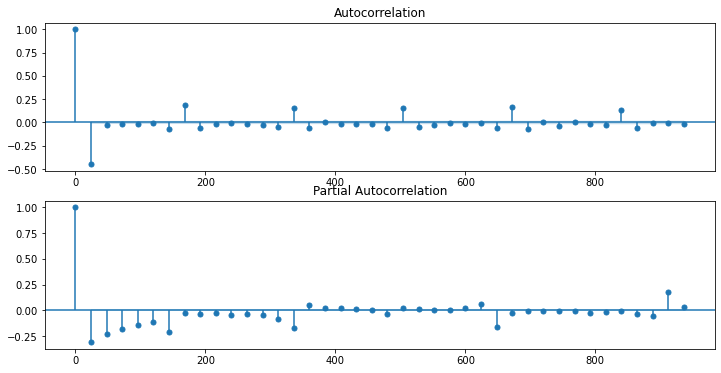

In [24]:
# Seasonal autocorrelation for seasonally differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df_tr, df_ts = df.iloc[:-500], df.iloc[-500:]

In [7]:
def evaluate_model(data, column, order, seasonal_order, n_splits=5, 
                   max_train_size=10000, test_size=1000, dynamic=False):
    
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size, test_size=test_size)
    mae = []
    
    for train_index, test_index in tscv.split(data):
        train, test = data.reset_index().loc[train_index], data.reset_index().loc[test_index]
        
        model = SARIMAX(train[column], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        
        pred = model_fit.get_prediction(start=test.index.values[0], end = test.index.values[-1], dynamic=dynamic)
        pred_ci = pred.conf_int()
    
        mae.append(mean_absolute_error(test[column], pred.predicted_mean))

    cv_error = np.mean(mae)
    aic_avg = np.mean(model_fit.aic)
    
    return cv_error, aic_avg

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of p, q and q triplets and seasonal P, D, Q n n
D = [1]
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, D, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[5]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 1, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 2, 24)
SARIMAX: (0, 1, 0) x (1, 1, 2, 24)


In [9]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def grid_search(data, column, order, seasonal_order, dynamic=False):
    best_score, best_cfg, best_scfg=float('inf'), None, None
    for params in order:
        for seasonal_params in seasonal_order:
            try:
                mae, aic = evaluate_model(data, column, params, seasonal_params, dynamic=dynamic)
                if aic < best_score:
                    best_score, best_cfg, best_scfg = aic, params, seasonal_params
                print('ARIMA: {} X {}, MEAN AIC = {}'.format(params, seasonal_params, round(aic)))
            except:
                continue
    return print('Best ARIMA: {} X {}, MEAN AIC = {}'.format(best_cfg, best_scfg, best_score))

In [20]:
# Find the optimum ARIMA parameters
grid_search(df_tr, 'SFO', pdq, seasonal_pdq)

ARIMA: (0, 0, 0) X (0, 1, 0, 24), MEAN AIC = 142018
ARIMA: (0, 0, 0) X (0, 1, 1, 24), MEAN AIC = 138433
ARIMA: (0, 0, 0) X (0, 1, 2, 24), MEAN AIC = 138011
ARIMA: (0, 0, 0) X (1, 1, 0, 24), MEAN AIC = 141081
ARIMA: (0, 0, 0) X (1, 1, 1, 24), MEAN AIC = 138156
ARIMA: (0, 0, 0) X (1, 1, 2, 24), MEAN AIC = 137868
ARIMA: (0, 0, 0) X (2, 1, 0, 24), MEAN AIC = 139611
ARIMA: (0, 0, 0) X (2, 1, 1, 24), MEAN AIC = 137801
ARIMA: (0, 0, 0) X (2, 1, 2, 24), MEAN AIC = 137530
ARIMA: (0, 0, 1) X (0, 1, 0, 24), MEAN AIC = 139688
ARIMA: (0, 0, 1) X (0, 1, 1, 24), MEAN AIC = 135601
ARIMA: (0, 0, 1) X (0, 1, 2, 24), MEAN AIC = 135375
ARIMA: (0, 0, 1) X (1, 1, 0, 24), MEAN AIC = 138385
ARIMA: (0, 0, 1) X (1, 1, 1, 24), MEAN AIC = 135431
ARIMA: (0, 0, 1) X (1, 1, 2, 24), MEAN AIC = 135602
ARIMA: (0, 0, 1) X (2, 1, 0, 24), MEAN AIC = 137196
ARIMA: (0, 0, 1) X (2, 1, 1, 24), MEAN AIC = 135258
ARIMA: (0, 0, 1) X (2, 1, 2, 24), MEAN AIC = 135381
ARIMA: (0, 0, 2) X (0, 1, 0, 24), MEAN AIC = 138567
ARIMA: (0, 0

ARIMA: (2, 1, 2) X (1, 1, 2, 24), MEAN AIC = 132127
ARIMA: (2, 1, 2) X (2, 1, 0, 24), MEAN AIC = 134137
ARIMA: (2, 1, 2) X (2, 1, 1, 24), MEAN AIC = 132092
ARIMA: (2, 1, 2) X (2, 1, 2, 24), MEAN AIC = 132138
Best ARIMA: (1, 0, 1) X (2, 1, 1, 24), MEAN AIC = 12.0


In [7]:
def best_model(column, order, seasonal_order, dynamic=False):    
    
    model = SARIMAX(df_tr[column], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
        
    pred = model_fit.get_prediction(start=df_ts.index.values[0], end = df_ts.index.values[-1], dynamic=dynamic)
    pred_ci = pred.conf_int()
    
    ax = df_ts.SFO.plot(figsize=(14,6), label='observed', linewidth=3, color = 'orange')
    pred.predicted_mean.plot(ax=ax, alpha=0.7, label='predicted', linewidth=3, color='black', linestyle='--')
    ax.legend()
    plt.show()
    
    error = mean_absolute_error(df_ts.SFO, pred.predicted_mean)
    print(f'AIC: {model_fit.aic}')
    print(f'MAE: {error}')
    
    return model_fit

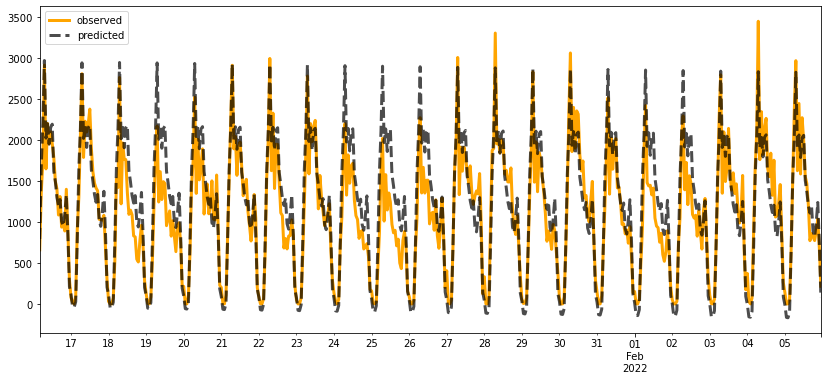

AIC: 368657.8869637784
MAE: 227.15050275580694


In [15]:
fit1 = best_model('SFO', (1, 1, 2), (2, 1, 1, 24), dynamic=True)

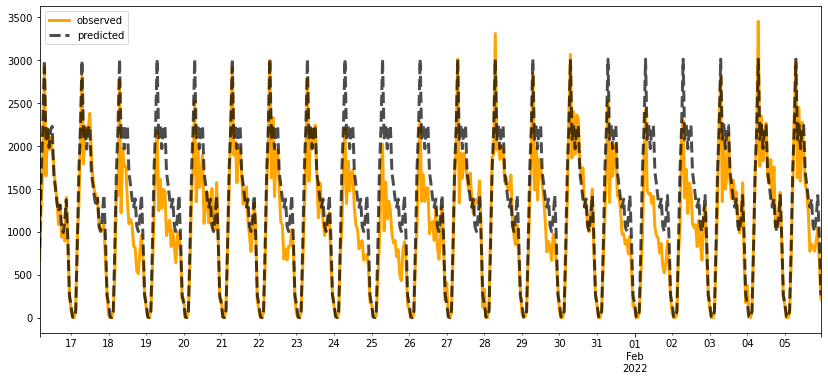

AIC: 367658.78506720794
MAE: 255.37166876335394


In [16]:
fit2 = best_model('SFO', (2, 0, 2), (2, 1, 1, 24), dynamic=True)

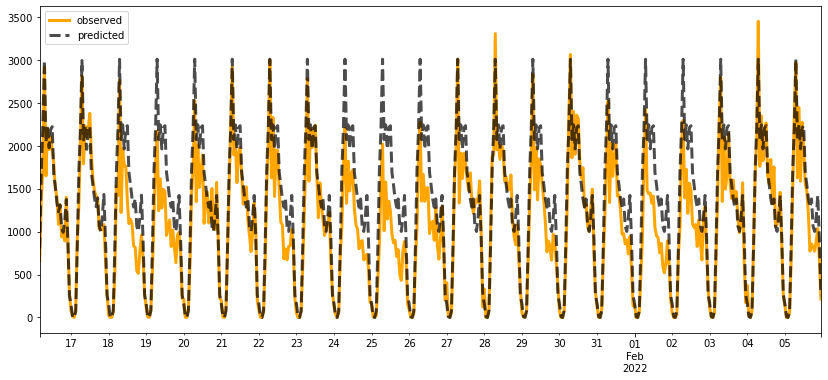

AIC: 367665.20527948823
MAE: 254.57261942407925


In [8]:
fit3 = best_model('SFO', (1, 0, 1), (2, 1, 1, 24), dynamic=True)

In [12]:
final_model = SARIMAX(df.SFO, order=(1, 1, 2), seasonal_order=(2, 1, 1, 24))
fitted_model = final_model.fit(disp=0)

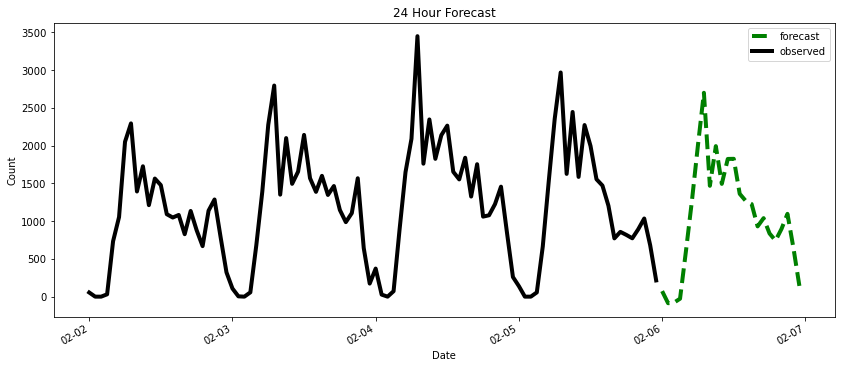

In [13]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (14, 6))
ax.plot(fitted_model.forecast(24), color = 'green', linewidth = 4, linestyle = '--', label='forecast')
ax.plot(df.SFO.loc['2022-02-02':], color = 'black', linewidth = 4, label = 'observed')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('24 Hour Forecast')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
ax.legend();

In [11]:
df.to_csv('../data/processed/airports_processed.csv')